In [ ]:

#  This NoteBook contains code to run classic ML routines against a 
#  number of familiar data swets ..
#


#  Step 00: Setup

In [ ]:

#  Largely code to control how print statements and related work
#

%load_ext autoreload
%autoreload 2

%xmode Minimal


#  Setting display options 
#
import pandas as pd
pd.set_option("display.width", 640)
   #
import numpy as np
np.set_printoptions(edgeitems = 30, linewidth = 100000, 
   formatter = dict(float = lambda x: "%.3g" % x))

#  Sets horizontal scroll for wide outputs
#
from IPython.display import display, HTML
display(HTML(""))

   ###
    
from tabulate import tabulate
#
#  How to use tabulate-
#
#  l_result = [{ "col1": 20, "col2": 30}]
#  #
#  print(tabulate(l_result, headers='keys', tablefmt='psql', showindex=False))

print("--")


In [ ]:

#  Helper functions for what we want to do below-
#

#  We use these objects to store the history of results; display only
#
class HistoryIterator:
   def __init__(self, history):
       self._history = history
       self._index = 0

   def __next__(self):
       if (self._index < len(self._history._events)):
           result = (self._history._events[self._index]["event"] , self._history._events[self._index]["measure"])
           self._index +=1
           return result
       raise StopIteration

class History:
   def __init__(self):
      self._events = list()

   def clear(self):
      self._events = list()
    
   def add(self, event, measure):
      self._events.append({"event": event, "measure": measure})

   def __iter__(self):
      return HistoryIterator(self)


l_history = History()


#  The sklearn ML routines follow a very consistent pattern. As such, we
#  put these in a function, reduce redundant code below-
#

def do_model(i_routine, i_train_data, i_train_labels, i_test_data, i_test_labels, i_name_of_test):

   #  Train whatever model
   #
   i_routine.fit(i_train_data, i_train_labels)
   
   #  Predict on the test data
   #
   l_predicted_labels = i_routine.predict(i_test_data)
   l_accuracy         = (i_routine.score(i_test_data, i_test_labels) * 100)
      #
   l_history.add(event = i_name_of_test, measure = l_accuracy)
   
   #  Output results
   #
   print(i_name_of_test + " ...")
   print("   Actual    labels from test......... %s" % (i_test_labels     ) )
   print("   Predicted labels from test......... %s" % (l_predicted_labels) )
   print(   "   ###")
   print("   Accuracy: %0.4f %%" % (l_accuracy))


print("--")



In [ ]:

#  Sometimes we want to clear history-
#

l_history.clear()

print("--")


In [ ]:

#  To add a blank line to history-
#

l_history.add(event = "", measure = "")

print("--")


#  Step A1: Iris Data load, encode

In [ ]:

#  Read the Iris data into a Pandas Dataframe
#
#     Features
#     1. sepal length in cm
#     2. sepal width in cm
#     3. petal length in cm
#     4. petal width in cm
#     5. class: 
#        Iris-setosa
#        Iris-versicolour
#        Iris-virginica
#
#  To convert class into a numeric, we use sklearn.preprocessing.LabelEncoder
#  See,
#     https://www.turing.com/kb/convert-categorical-data-in-pandas-and-scikit-learn
#

from sklearn.preprocessing import LabelEncoder

my_le = LabelEncoder()
   #
l_folder = "20_Data"
l_file   = "11_iris.data.txt"


pd_iris  = pd.read_csv((l_folder + "/" + l_file), header = 0, sep = ",",
   names = ["sl", "sw", "pl", "pw", "class"],
   dtype = {"sl": "float", "sw": "float", "pl": "float", "pw": "float", "class": "string"} )
      #
pd_iris["class_encoded"]  =  my_le.fit_transform(pd_iris["class"])
   #
pd_iris = pd_iris.drop(["class"], axis = 1)
    
    
#  Pandas.Dataframe.sample() returns a randomized set of rows, versus
#  say head(), which always returns the first n ..
#
print(tabulate(pd_iris.sample(5), headers='keys', tablefmt='psql', showindex=False))
print("Number of rows: %d" % (len(pd_iris)))

print("--")


In [ ]:

#  Split data into training and test.
#  Convert the data into numpy arrays, since the ml libraries we use later expect that.
#

import numpy as np
from sklearn.model_selection import train_test_split

np_iris = {}
   #
np_iris["train"], np_iris["test"] = train_test_split(pd_iris.to_numpy(),              #  random_state calls to shuffle the data,
   test_size = 0.20, random_state = 40)                                               #    which had arrived sorted
                                                                                      #  10% yields way too high of an accuracy
                                                                                      #    far below
print("Number of total rows: %d   Training rows: %d   Test rows: %d" %
  (len(pd_iris), len(np_iris["train"]), len(np_iris["test"])) )

print()
print("Train data:")
print("%s" % (np_iris["train"][0:5]))
print()
print("Test  data:")
print("%s" % (np_iris["test" ][0:5]))
print()
   #
print("--")


<class 'numpy.ndarray'>


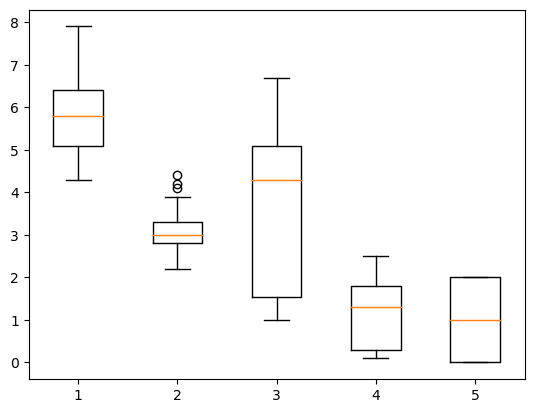

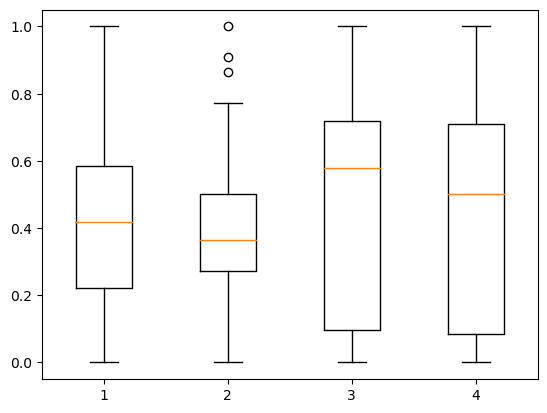

--


In [28]:

#  Boxplot, and normalize ..
#
#  Normalize from,
#     https://datascience.stackexchange.com/questions/39142/normalize-matrix-in-python-numpy
#

import matplotlib.pyplot as plt 
   #
from sklearn.preprocessing import MinMaxScaler

print(type(np_iris["train"]))

plt.boxplot(np_iris["train"])
plt.show()

   ###

def my_normalize(X, x_min, x_max):
   nom = (X-X.min(axis=0))*(x_max-x_min)
   denom = X.max(axis=0) - X.min(axis=0)
   denom[denom==0] = 1
   return x_min + nom/denom 

#  If we normalize the "class" column, we lose the categroical nature
#  of that data.

np_iris["train_norm"] = np.copy(np_iris["train"])
np_iris["test_norm" ] = np.copy(np_iris["test" ])

np_iris["train_norm"] = my_normalize(np_iris["train_norm"][:, :4], 0, 1)
np_iris["test_norm" ] = my_normalize(np_iris["test_norm" ][:, :4], 0, 1)

plt.boxplot(np_iris["train_norm"])
plt.show()


print("--")


In [29]:

print("Train data:")
print("%s" % (np_iris["train_norm"][0:5]))


Train data:
[[0.5 0.318 0.649 0.542]
 [0.139 0.545 0.158 0.0417]
 [0.25 0.591 0.0877 0.0417]
 [0.194 0.5 0.0702 0.0417]
 [0.0833 0.409 0.0877 0.0417]]


#  Step A2: Iris Data train, test .. NearestCentroid

In [ ]:

from sklearn.neighbors import NearestCentroid

#  Our numpy array has 5 columns, with the last column being the class.
#  To review numpy array slicing,
#
#     To get the first 4 columns use,
#        np_iris["train"][:, :4]
#     To get the last column use,
#        np_iris["train"][:, -1]
#

do_model(NearestCentroid(), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: Centroid") 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

do_model(NearestCentroid(), np_iris["train_norm"][:, :4], np_iris["train"][:, -1], np_iris["test_norm"][:, :4], np_iris["test"][:, -1], "Iris: Centroid Normalized") 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

print("--")
    

#  Step A3: Iris Data train, test .. kNN

In [ ]:

from sklearn.neighbors import KNeighborsClassifier

#  Our numpy array has 5 columns, with the last column being the class.
#  To review numpy array slicing,
#
#     To get the first 4 columns use,
#        np_iris["train"][:, :4]
#     To get the last column use,
#        np_iris["train"][:, -1]
#

do_model(KNeighborsClassifier(n_neighbors = 3), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: kNN=3" ) 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

print("--")


#  Step A4: Iris Data train, test .. Naive Bayes, Gaussian

In [ ]:

from sklearn.naive_bayes import GaussianNB

#  Naive Bayes, Gaussian
#
#     Gaussian usually does better than the Multinomial below because,
#        Gaussian expects continuous values
#        Multinomial expects discreet values
#
#     And our values are continuous
#

do_model(GaussianNB(), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: GaussianNB" ) 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

print("--")


#  Step A5: Iris Data train, test .. Naive Bayes, Multinomial

In [ ]:

from sklearn.naive_bayes import MultinomialNB

#  Naive Bayes, Multinomial
#

do_model(MultinomialNB(), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: MultinomialNB" ) 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

print("--")


#  Step A6: Iris Data train, test .. Decision Tree

In [ ]:

from sklearn.tree import DecisionTreeClassifier

#  Decision Tree
#

do_model(DecisionTreeClassifier(), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: DecisionTree" ) 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

print("--")


#  Step A7: Iris Data train, test .. Random Forest

In [ ]:

from sklearn.ensemble import RandomForestClassifier

#  Random Forest
#

#  n_estimators, number of random trees created and trained
#

do_model(RandomForestClassifier(n_estimators = 5), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: RandomForest" ) 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

print("--")


#  Step A8: Iris Data train, test .. Support Vector Machine (SVM)

In [ ]:

from sklearn.svm import SVC

#  Support Vector Machine
#
#  We run this one with a number of configurations ..
#
#     C      ==  margin constant
#     gamma  ==  used by the Gaussian kernel
#

do_model(SVC(kernel = "linear", C = 1.0), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: SVC/Linear" ) 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))
print()
             
do_model(SVC(kernel = "rbf", C = 1.0, gamma = 0.25), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: RBF" ) 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))
print()
             
do_model(SVC(kernel = "rbf", C = 1.0, gamma = 0.001), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: RBF 2" ) 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))
print()

print("--")


In [ ]:

####################################################################
####################################################################
####################################################################


#  Step B1:  Breast Cancer Data load, encode, normalize

In [ ]:

#  Read the Breast Cancer data into a Pandas Dataframe
#
#     Features
#     1)     ID number
#     2)     Diagnosis (M = malignant, B = benign)
#     3-32)
#       Ten real-valued features are computed for each cell nucleus:
#     
#     	a) radius (mean of distances from center to points on the perimeter)
#     	b) texture (standard deviation of gray-scale values)
#     	c) perimeter
#     	d) area
#     	e) smoothness (local variation in radius lengths)
#     	f) compactness (perimeter^2 / area - 1.0)
#     	g) concavity (severity of concave portions of the contour)
#     	h) concave points (number of concave portions of the contour)
#     	i) symmetry 
#     	j) fractal dimension ("coastline approximation" - 1)
#
#  Sample data line,
#     842302,M,
#     17.99,    10.38,    122.8,    1001,    0.1184,    0.2776,    0.3001,    0.1471,    0.2419,    0.07871,         #  10 count
#     1.095,    0.9053,   8.589,    153.4,   0.006399,  0.04904,   0.05373,   0.01587,   0.03003,   0.006193,
#     25.38,    17.33,    184.6,    2019,    0.1622,    0.6656,    0.7119,    0.2654,    0.4601     ,0.1189
#

from sklearn.preprocessing import LabelEncoder

my_le = LabelEncoder()
   #
l_folder = "20_Data"
l_file   = "22_wdbc.data.txt"


pd_bc  = pd.read_csv((l_folder + "/" + l_file), header = 0, sep = ",",
   names = ["id", "class",
            "f01", "f02", "f03", "f04", "f05", "f06", "f07", "f08", "f09", "f10", 
            "f11", "f12", "f13", "f14", "f15", "f16", "f17", "f18", "f19", "f20", 
            "f21", "f22", "f23", "f24", "f25", "f26", "f27", "f28", "f29", "f30", 
           ],
   dtype = {"id": "int", "class": "string",
            "f01": "float", "f02": "float", "f03": "float", "f04": "float", "f05": "float", "f06": "float", "f07": "float", "f08": "float", "f09": "float", "f10": "float", 
            "f11": "float", "f12": "float", "f13": "float", "f14": "float", "f15": "float", "f16": "float", "f17": "float", "f18": "float", "f19": "float", "f20": "float", 
            "f21": "float", "f22": "float", "f23": "float", "f24": "float", "f25": "float", "f26": "float", "f27": "float", "f28": "float", "f29": "float", "f30": "float", 
           } )
      #
pd_bc["class_encoded"]  =  my_le.fit_transform(pd_bc["class"])
   #
pd_bc = pd_bc.drop(["class", "id"], axis = 1)
    
    
#  Pandas.Dataframe.sample() returns a randomized count of rows
#
print(tabulate(pd_bc.sample(5), headers='keys', tablefmt='psql', showindex=False))
print("Number of rows: %d" % (len(pd_bc)))

print("--")


In [ ]:

#  Split data into training and test.
#  Convert the data into numpy arrays, since the ml libraries we use later expect that.
#

import numpy as np
from sklearn.model_selection import train_test_split

np_bc = {}
   #
np_bc["train"], np_bc["test"] = train_test_split(pd_bc.to_numpy(),                    #  random_state calls to shuffle the data,
   test_size = 0.20, random_state = 40)                                               #    which had arrived sorted
                                                                                      #  10% yields way too high of an accuracy
                                                                                      #    far below
print("Number of total rows: %d   Training rows: %d   Test rows: %d" %
  (len(pd_bc), len(np_bc["train"]), len(np_bc["test"])) )

print()
print("Train data:")
print("%s" % (np_bc["train"][0:5]))
print()
print("Test  data:")
print("%s" % (np_bc["test" ][0:5]))
print()
   #
print("--")


#  Step B2:  Breast Cancer Data, run against all models ..

In [ ]:

#  All of our model libraries were imported above, but ..
#
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


#  To add a blank line to history-
#
l_history.add(event = "", measure = "")


#  Our numpy array has many columns, with the last column being the class.
#
#  To review numpy array slicing,
#
#     To get the first 30 columns use,
#        np_iris["train"][:, :30]
#     To get the last column use,
#        np_iris["train"][:, -1]
#

do_model(NearestCentroid(), np_bc["train"][:, :4], np_bc["train"][:, -1], np_bc["test"][:, :4], np_bc["test"][:, -1], "Breast Cancer: Centroid") 
print()

do_model(KNeighborsClassifier(n_neighbors = 3), np_bc["train"][:, :4], np_bc["train"][:, -1], np_bc["test"][:, :4], np_bc["test"][:, -1], "Breast Cancer: kNN=3") 
print()

do_model(GaussianNB(), np_bc["train"][:, :4], np_bc["train"][:, -1], np_bc["test"][:, :4], np_bc["test"][:, -1], "Breast Cancer: GaussianNB") 
print()

do_model(MultinomialNB(), np_bc["train"][:, :4], np_bc["train"][:, -1], np_bc["test"][:, :4], np_bc["test"][:, -1], "Breast Cancer: MultinomialNB") 
print()

do_model(DecisionTreeClassifier(), np_bc["train"][:, :4], np_bc["train"][:, -1], np_bc["test"][:, :4], np_bc["test"][:, -1], "Breast Cancer: DecisionTree") 
print()

#  n_estimators, number of random trees created and trained
#
do_model(RandomForestClassifier(n_estimators = 5), np_bc["train"][:, :4], np_bc["train"][:, -1], np_bc["test"][:, :4], np_bc["test"][:, -1], "Breast Cancer: Random Forest = 5") 
print()

   ###

#  Support Vector Machine
#
#  We run this one with a number of configurations ..
#
#     C      ==  margin constant
#     gamma  ==  used by the Gaussian kernel
#

do_model(SVC(kernel = "linear", C = 1.0), np_bc["train"][:, :4], np_bc["train"][:, -1], np_bc["test"][:, :4], np_bc["test"][:, -1], "Breast Cancer: SVC/Linear") 
print()

do_model(SVC(kernel = "rbf", C = 1.0, gamma = 1.0), np_bc["train"][:, :4], np_bc["train"][:, -1], np_bc["test"][:, :4], np_bc["test"][:, -1], "Breast Cancer: RBF") 
print()

do_model(SVC(kernel = "rbf", C = 1.0, gamma = 0.001), np_bc["train"][:, :4], np_bc["train"][:, -1], np_bc["test"][:, :4], np_bc["test"][:, -1], "Breast Cancer: RBF 2") 
print()


print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))
print()

print("--")
